# Model Exploration Notebook

This notebook gives details about the various techniques tried out during the course of this assignment

1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from tensorflow.keras.layers import Dense,Input,LSTM,Embedding,GRU
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Nadam,Adam,RMSprop,SGD
from tensorflow.random import set_seed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


2. Load Data that was saved using the main.py script

In [2]:
X = np.load("../data/X.npy")
y = np.load("../data/Y.npy")

3. Split data into train and test:
Test data will only be used at the end for inference,
Validation data will be taken from the training data itself

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Intuition: I tried out classical ML models with raw data but I could only get an R2 score of 0.6. Since using fft we are able to convert the signal from time to frequency domain and get the frequency peaks, we can find some kind of a relationship (possibly linear) between the features and the labels. So I applied fft on the signal

In [38]:
feats = np.abs(np.fft.fft(X,axis=1))
feats_X_train,feats_X_test,feats_y_train,feats_y_test = train_test_split(feats,y,test_size=0.2,random_state=42)

## Classical ML Models
4. Try out various ML models

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
tree = DecisionTreeRegressor()
tree.fit(feats_X_train,feats_y_train)


rf = RandomForestRegressor()
rf.fit(feats_X_train,feats_y_train)

xgb = XGBRegressor()
xgb.fit(feats_X_train,feats_y_train)

lr = LinearRegression()
lr.fit(feats_X_train,feats_y_train)

LinearRegression()

In [46]:
y_tree = tree.predict(feats_X_test)
y_forest = rf.predict(feats_X_test)
y_xgb = xgb.predict(feats_X_test)
y_linear = lr.predict(feats_X_test)

In [48]:
from sklearn.metrics import mean_squared_error,r2_score

def calc_metrics(y_true,y_preds,name):
    r2 = r2_score(y_true,y_preds)
    mse = mean_squared_error(y_true,y_preds)
    print(name," ","MSE: ",mse)
    print(name," ","R2: ",r2)


    
calc_metrics(feats_y_test,y_tree,"DTREE")
calc_metrics(feats_y_test,y_forest,"Forest")
calc_metrics(feats_y_test,y_xgb,"XGB")
calc_metrics(feats_y_test,y_linear,"Linear Reg")

DTREE   MSE:  73.53600500000209
DTREE   R2:  0.6432245429785599
Forest   MSE:  34.917328657500995
Forest   R2:  0.8305912064471357
XGB   MSE:  37.68495654539357
XGB   R2:  0.8171634753028054
Linear Reg   MSE:  36.667593877442705
Linear Reg   R2:  0.8220994251251369


As clearly visible we get the best results for the random forest regressor. Notably even linear regression gives good results since there exists a good linear realtionship between fft features and the frequency labels

5. Set seed

In [49]:
np.random.seed(42)
set_seed(42)

6. Define Model

Architecture of the model was based on this paper : https://nanoconvergencejournal.springeropen.com/articles/10.1186/s40580-019-0197-y

## Create Dense NN Model

In [70]:
def create_model(config):
    model = Sequential()
    model.add(Input(shape=(20,)))
    model.add(Dense(2,activation="linear"))
    model.add(Dense(2,activation="linear"))
    model.add(Dense(3,activation="linear"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(optimizer=config["opt"],loss=config["loss"])
    return model

In [71]:
config = {
    "opt": Nadam(lr=0.001),
    "loss":MeanSquaredError(),
    
}

7. Set up callback to run best model

In [72]:
checkpoint_callback = ModelCheckpoint("checkpoint/checkpoint.ckpt",monitor="val_loss",save_best_only=True,save_weights_only=True)

8. Set up K Fold CV

In [73]:
model_args = {
    "batch_size":16,
    "epochs": 30,
    }

In [74]:

def KFoldCrossValidate(X_train,y_train,n_splits,config,model_args=model_args,callbacks=None,model_func=create_model):
    kf = KFold(n_splits=n_splits)
    for ii,(train_index,val_index) in enumerate(kf.split(X_train)):
        X_fold,X_fold_val = X_train[train_index],X_train[val_index]
        y_fold,y_fold_val = y_train[train_index],y_train[val_index]
        model = model_func(config)
        if callbacks!=None:
            history = model.fit(x=X_fold,y=y_fold,batch_size=model_args["batch_size"],epochs=model_args["epochs"],validation_data=(X_fold_val,y_fold_val),callbacks=callbacks)
        else:
            history = model.fit(x=X_fold,y=y_fold,batch_size=model_args["batch_size"],epochs=model_args["epochs"],validation_data=(X_fold_val,y_fold_val))
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Fold ",)
        plt.legend(["train_loss","val_loss"],loc="upper right")
        plt.show()

1. One may wonder why no activations were used in the model. While experimenting, I did use a combination of various activations, but it just didnt seem to be as accurate as the classical machine learning models since the prediction function learnt was probably too complex.
2. Without using any activations there is no non linearity introduced. Hence the model is as good as a regression model which takes away the use of a neural network, which is why my final choice of a model would be random forest.
3. In addition to this RNN's were also tested with the raw data (as seen below) which gave pretty good result. Intuition was that RNN's take into account temporal information between individual timesteps, which is a good set of features when determining frequency
4. Also, it is also noticed that labels have been scaled by dividing by 100. Through experiments as well as it was mentioned in the paper linked above that the network was able to be much more accurate when the label was scaled. This(div by 100) was the best working scale that I found.

Epoch 1/30
400/400 [==============================] - 1s 829us/step - loss: 0.0502 - val_loss: 0.0158
Epoch 2/30
400/400 [==============================] - 0s 596us/step - loss: 0.0151 - val_loss: 0.0132
Epoch 3/30
400/400 [==============================] - 0s 590us/step - loss: 0.0128 - val_loss: 0.0107
Epoch 4/30
400/400 [==============================] - 0s 608us/step - loss: 0.0098 - val_loss: 0.0088
Epoch 5/30
400/400 [==============================] - 0s 605us/step - loss: 0.0077 - val_loss: 0.0064
Epoch 6/30
400/400 [==============================] - 0s 600us/step - loss: 0.0061 - val_loss: 0.0055
Epoch 7/30
400/400 [==============================] - 0s 581us/step - loss: 0.0054 - val_loss: 0.0050
Epoch 8/30
400/400 [==============================] - 0s 597us/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/30
400/400 [==============================] - 0s 605us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 10/30
400/400 [==============================] - 0s 638us/step - loss: 0.004

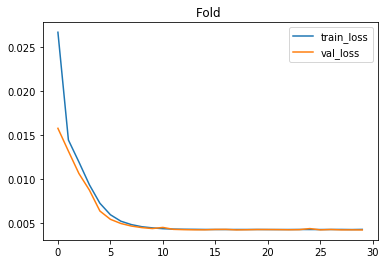

Epoch 1/30
400/400 [==============================] - 1s 736us/step - loss: 0.0226 - val_loss: 0.0130
Epoch 2/30
400/400 [==============================] - 0s 580us/step - loss: 0.0119 - val_loss: 0.0088
Epoch 3/30
400/400 [==============================] - 0s 643us/step - loss: 0.0084 - val_loss: 0.0060
Epoch 4/30
400/400 [==============================] - 0s 636us/step - loss: 0.0061 - val_loss: 0.0050
Epoch 5/30
400/400 [==============================] - 0s 558us/step - loss: 0.0051 - val_loss: 0.0044
Epoch 6/30
400/400 [==============================] - 0s 535us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 7/30
400/400 [==============================] - 0s 575us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/30
400/400 [==============================] - 0s 593us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 9/30
400/400 [==============================] - 0s 601us/step - loss: 0.0045 - val_loss: 0.0041
Epoch 10/30
400/400 [==============================] - 0s 643us/step - loss: 0.004

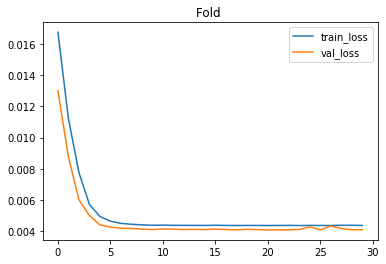

Epoch 1/30
400/400 [==============================] - 1s 749us/step - loss: 0.0273 - val_loss: 0.0141
Epoch 2/30
400/400 [==============================] - 0s 588us/step - loss: 0.0131 - val_loss: 0.0110
Epoch 3/30
400/400 [==============================] - 0s 555us/step - loss: 0.0104 - val_loss: 0.0085
Epoch 4/30
400/400 [==============================] - 0s 554us/step - loss: 0.0077 - val_loss: 0.0058
Epoch 5/30
400/400 [==============================] - 0s 578us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 6/30
400/400 [==============================] - 0s 674us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 7/30
400/400 [==============================] - 0s 625us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 8/30
400/400 [==============================] - 0s 709us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/30
400/400 [==============================] - 0s 656us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/30
400/400 [==============================] - 0s 520us/step - loss: 0.004

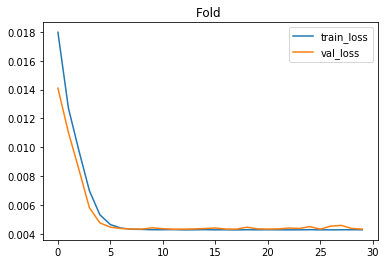

Epoch 1/30
400/400 [==============================] - 1s 746us/step - loss: 0.0130 - val_loss: 0.0062
Epoch 2/30
400/400 [==============================] - 0s 560us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 3/30
400/400 [==============================] - 0s 564us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 4/30
400/400 [==============================] - 0s 580us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 5/30
400/400 [==============================] - 0s 818us/step - loss: 0.0041 - val_loss: 0.0046
Epoch 6/30
400/400 [==============================] - 0s 595us/step - loss: 0.0042 - val_loss: 0.0045
Epoch 7/30
400/400 [==============================] - 0s 662us/step - loss: 0.0042 - val_loss: 0.0045
Epoch 8/30
400/400 [==============================] - 0s 541us/step - loss: 0.0042 - val_loss: 0.0045
Epoch 9/30
400/400 [==============================] - 0s 534us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/30
400/400 [==============================] - 0s 565us/step - loss: 0.004

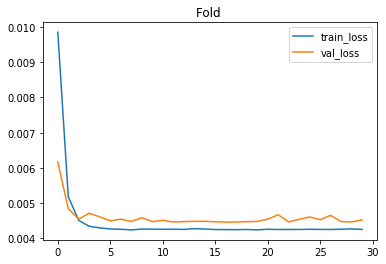

Epoch 1/30
400/400 [==============================] - 1s 739us/step - loss: 0.0165 - val_loss: 0.0082
Epoch 2/30
400/400 [==============================] - 0s 672us/step - loss: 0.0069 - val_loss: 0.0050
Epoch 3/30
400/400 [==============================] - 0s 661us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 4/30
400/400 [==============================] - 0s 690us/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/30
400/400 [==============================] - 0s 551us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 6/30
400/400 [==============================] - 0s 570us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/30
400/400 [==============================] - 0s 563us/step - loss: 0.0041 - val_loss: 0.0043
Epoch 8/30
400/400 [==============================] - 0s 568us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/30
400/400 [==============================] - 0s 762us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/30
400/400 [==============================] - 0s 565us/step - loss: 0.004

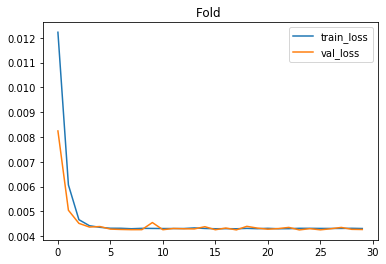

In [75]:
KFoldCrossValidate(X_train,y_train/100,5,config,model_args,[checkpoint_callback])

In [76]:
def infer(X_test,y_test,model_func,path_to_model,config=config,preproc_func=None):
    model = model_func(config)
    model.load_weights(path_to_model)
    if preproc_func!=None:
        X_test,y_test = preproc_func(X_test,y_test)
    
    y_pred = model.predict(X_test)
    
    print("MSE: ",mean_squared_error(y_test,y_pred))
    print("R2: ",r2_score(y_test,y_pred))

In [77]:
infer(X_test,y_test/100,create_model,"checkpoint/checkpoint.ckpt")

MSE:  0.004047179274755937
R2:  0.8036425509655155


## Create Sequential RNN Model

In [30]:
def create_rnn_model(config):
    rnn_model = Sequential()
    rnn_model.add(LSTM(16,input_shape=(20,1)))
    rnn_model.add(Dense(10,activation="relu"))

    rnn_model.add(Dense(1,activation="sigmoid"))
    rnn_model.compile(optimizer=config["opt"],loss=config["loss"])
    return rnn_model

In [31]:
def preproc_rnn(X,y):
    X_rnn = X.reshape(-1,20,1)
    y_rnn = y/100
    return X_rnn,y_rnn

X_rnn,y_rnn = preproc_rnn(X_train,y_train)

In [32]:
model_args_rnn = {
    "batch_size": 16,
    "epochs": 30
    
}

In [33]:
rnn_cp = ModelCheckpoint("rnn_cp/rnn.ckpt",monitor="val_loss",save_best_only=True,save_weights_only=True)

Epoch 1/30
400/400 [==============================] - 2s 3ms/step - loss: 0.0124 - val_loss: 0.0038
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 5/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 6/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 9/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0036

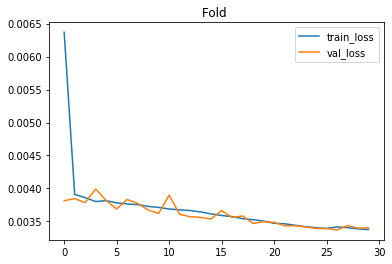

Epoch 1/30
400/400 [==============================] - 2s 3ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/30
400/400 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 10/30
400/400 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0036

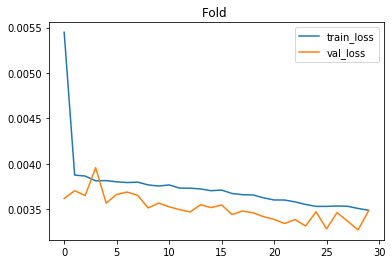

Epoch 1/30
400/400 [==============================] - 2s 3ms/step - loss: 0.0148 - val_loss: 0.0039
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 5/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 6/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 7/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0036

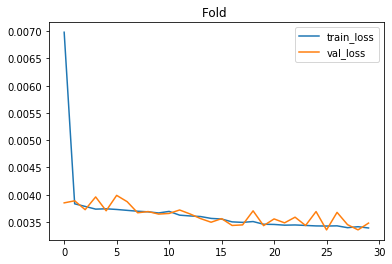

Epoch 1/30
400/400 [==============================] - 2s 3ms/step - loss: 0.0089 - val_loss: 0.0038
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 5/30
400/400 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 6/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0036

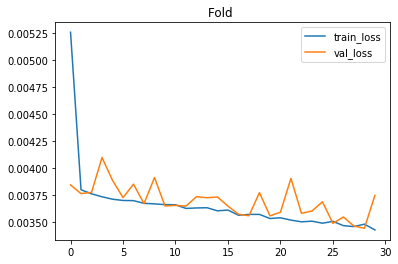

Epoch 1/30
400/400 [==============================] - 2s 4ms/step - loss: 0.0140 - val_loss: 0.0038
Epoch 2/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 3/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 4/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 6/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 7/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 8/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/30
400/400 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0038

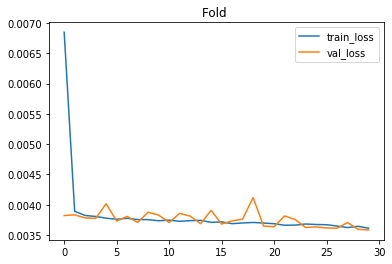

In [35]:
KFoldCrossValidate(X_rnn,y_rnn,5,config,model_args_rnn,[rnn_cp],create_rnn_model)

In [37]:
from sklearn.metrics import r2_score,mean_squared_error
print("BEST RNN MODEL RESULTS: ")
infer(X_test,y_test,create_rnn_model,"rnn_cp/rnn.ckpt",preproc_func=preproc_rnn)

BEST RNN MODEL RESULTS: 
MSE:  0.0032888826220776207
R2:  0.8404329143823379


## Conclusion
Since my experiments made me realize that RNN was the best model option, I'll be adding it to the training script